# Exercise 14: Trends in IN Snow

In this exercise, we will build on geospatial skills from last week to assemble a dataset of snow observations in Indiana from a global dataset of meteorological observations.  The aim will be to ask whether there are trends in snow in IN.  This exercise will involve automatically downloading data from an external source.

The source dataset is: https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily

In [1]:
""" Import libraries. """
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs
import geopandas as gpd
import pandas as pd
from tqdm.notebook import tqdm # for a progress bar; you'll need to install tqdm and ipywidgets
import scipy

In [2]:
""" Load the inventory file. """

# set the inventory file
inventory_url = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt"

# load the inventory file into a pandas dataframe
inventory_pd = pd.read_fwf(inventory_url, header=None, names=["ID", "LATITUDE", "LONGITUDE", "VARIABLE", "FIRSTYEAR", "LASTYEAR" ])
inventory_pd.head()

,ID,LATITUDE,LONGITUDE,VARIABLE,FIRSTYEAR,LASTYEAR
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949
1,ACW00011604,17.1167,-61.7833,TMIN,1949,1949
2,ACW00011604,17.1167,-61.7833,PRCP,1949,1949
3,ACW00011604,17.1167,-61.7833,SNOW,1949,1949
4,ACW00011604,17.1167,-61.7833,SNWD,1949,1949


In [3]:
""" Convert the inventory dataframe to a geopandas dataframe. """
inventory_gpd = gpd.GeoDataFrame(inventory_pd, geometry=gpd.points_from_xy(inventory_pd.LONGITUDE, inventory_pd.LATITUDE), crs = "EPSG:4326")

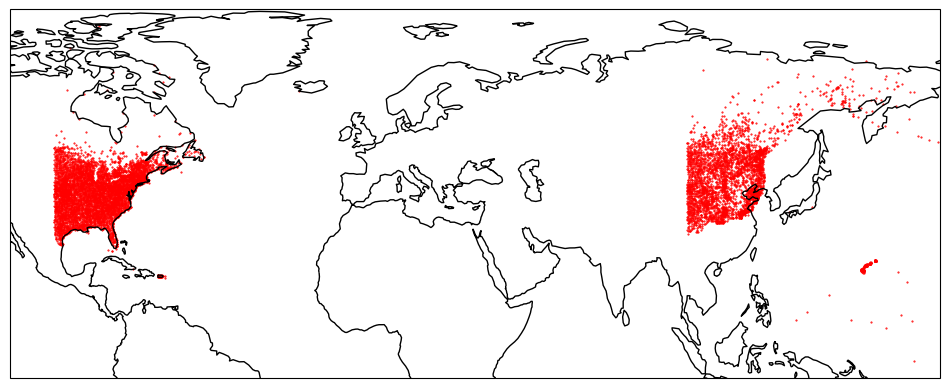

In [4]:
""" Find stations that have at least 50 years of data. """

# find stations that have at least 50 years of data
inventory_long_gpd = inventory_gpd[inventory_gpd.LASTYEAR - inventory_gpd.FIRSTYEAR >= 50]

projection = cartopy.crs.PlateCarree()

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=projection))

# plot the stations that have at least 50 years of SNOW data
inventory_long_gpd[inventory_long_gpd.VARIABLE == "SNOW"].plot(ax = ax, transform = projection, marker = '.', color = 'red', markersize = 1)

ax.coastlines()

plt.show()


There's something very off about the stations in China - it looks like lat/lons might be misreported by about 10-20 degrees North.  The sites in the US look reasonable; the reports are primarily over land, with some possible exceptions being islands.

In [5]:
""" Load the state boundary shapefile. """

# set the path to the shapefile
state_shapefile_path = "https://github.com/taobrienlbl/advanced_earth_science_data_analysis/raw/09188e9e6a0cf230f8473c0ae95d2e1b9079df3a/lessons/13_geospatial_intro/data/tl_2012_us_state.zip"

# load the state boundary shapefile
state_boundary_gdf = gpd.read_file(state_shapefile_path)

# plot the state boundary shapefile
state_boundary_gdf.head()

,OBJECTID,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,1,4,9,15,01779782,15,HI,Hawaii,00,G4000,A,1.663425e+10,1.167874e+10,+19.8097670,-155.5061027,2.419034e+06,3.268482e+10,"MULTIPOLYGON (((-17361760.204 2164544.588, -17..."
1,2,3,7,05,00068085,05,AR,Arkansas,00,G4000,A,1.347726e+11,2.959210e+09,+34.8955256,-092.4446262,2.656648e+06,2.053261e+11,"POLYGON ((-10515267.713 4101325.818, -10515269..."
2,3,4,8,35,00897535,35,NM,New Mexico,00,G4000,A,3.141611e+11,7.564385e+08,+34.4346843,-106.1316181,2.900368e+06,4.643927e+11,"POLYGON ((-12138963.727 4106855.170, -12138964..."
3,4,4,8,30,00767982,30,MT,Montana,00,G4000,A,3.769636e+11,3.868565e+09,+47.0511771,-109.6348174,4.607246e+06,8.201836e+11,"POLYGON ((-12727480.235 5886876.586, -12727567..."
4,5,1,2,36,01779796,36,NY,New York,00,G4000,A,1.220579e+11,1.923885e+10,+42.9133974,-075.5962723,3.212630e+06,2.637702e+11,"MULTIPOLYGON (((-8866092.533 5160809.769, -886..."


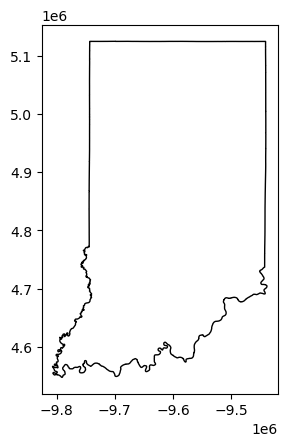

In [6]:
""" Extract the IN row. """
# extract the IN row
in_boundary_gdf = state_boundary_gdf[state_boundary_gdf.STUSPS == "IN"]

# plot the IN boundary
in_boundary_gdf.plot(facecolor = 'none', edgecolor = 'black');

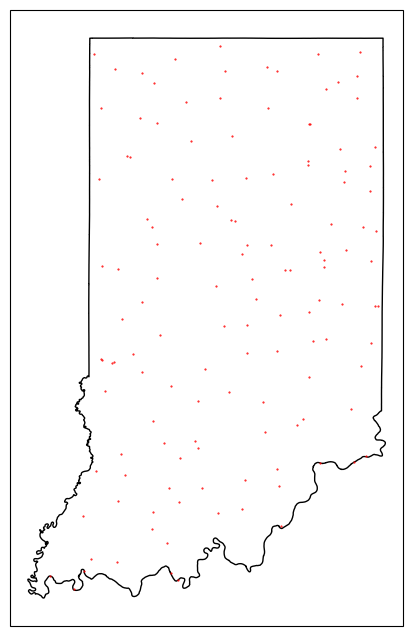

In [7]:
""" Use the IN boundary to clip the snow. """

# convert the in boundary to the same projection as the snow
in_boundary_transform_gdf = in_boundary_gdf.to_crs(inventory_long_gpd.crs)

# clip the snow to the IN boundary
in_snow_gdf = gpd.clip(inventory_long_gpd, in_boundary_transform_gdf)

# isolate this to just the SNOW variable
in_snow_gdf = in_snow_gdf[in_snow_gdf.VARIABLE == "SNOW"]

# plot the clipped snow and the state boundary
fig, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(12, 8))
in_boundary_transform_gdf.plot(ax = ax, transform = projection, facecolor = 'none', edgecolor = 'black')
in_snow_gdf.plot(ax = ax, transform = projection, marker = '.', color = 'red', markersize = 1)

plt.show()



In [8]:
""" Set the URL template for the GHCN-Daily data. """

def load_ghcn_data(station):
    
    url_template = "https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/{station}.csv"

    # set the station URL
    url = url_template.format(station = station)

    # load the data for the station
    station_pd = pd.read_csv(url)

    # return the station
    return station_pd

# test on the first station
station = in_snow_gdf.iloc[0].ID
test_pd = load_ghcn_data(station)
test_pd.head()


,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,...,MDSF,MDSF_ATTRIBUTES,WT01,WT01_ATTRIBUTES,WT04,WT04_ATTRIBUTES,WT16,WT16_ATTRIBUTES,WT18,WT18_ATTRIBUTES
0,USC00121998,1922-01-08,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,6",NaN,NaN
1,USC00121998,1922-01-13,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,6"
2,USC00121998,1922-01-18,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,6",NaN,NaN
3,USC00121998,1922-01-21,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,",,6",NaN,NaN,NaN,NaN
4,USC00121998,1922-02-01,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,6",NaN,NaN


In [9]:
""" Download data for all the stations. """
import warnings
station_pd_list = []
bad_station_list = []
warning_station_list = []

# catch warnings
warnings.filterwarnings("error")

print("Loading IN GHCN data...")
for station in tqdm(in_snow_gdf.ID):
    
    # load the data for the station
    try:
        # check for a warning and add to the warning list if there is one
        try:
            station_pd = load_ghcn_data(station)
            station_pd_list.append(station_pd)
        except RuntimeWarning:
            warning_station_list.append(station_pd)

    except:
        bad_station_list.append(station)
        continue

# go back to the default warning behavior
warnings.resetwarnings()



Loading IN GHCN data...


  0%|          | 0/134 [00:00<?, ?it/s]

In [10]:
""" Combine the data into a single dataframe. """
import datetime as dt
# combine the data into a single dataframe
in_ghcn_pd = pd.concat(station_pd_list + warning_station_list)

# save the data to a CSV file with today's date
in_ghcn_pd.to_csv(f"in_ghcnd_{dt.datetime.today().strftime('%Y-%m-%d')}.csv", index = False)

In [11]:
""" Convert the data to a geopandas dataframe. """

# parse the date column
in_ghcn_pd.DATE = pd.to_datetime(in_ghcn_pd.DATE)

# convert the data to a geopandas dataframe
in_ghcn_gpd = gpd.GeoDataFrame(in_ghcn_pd, geometry = gpd.points_from_xy(in_ghcn_pd.LONGITUDE, in_ghcn_pd.LATITUDE), crs = "EPSG:4326")

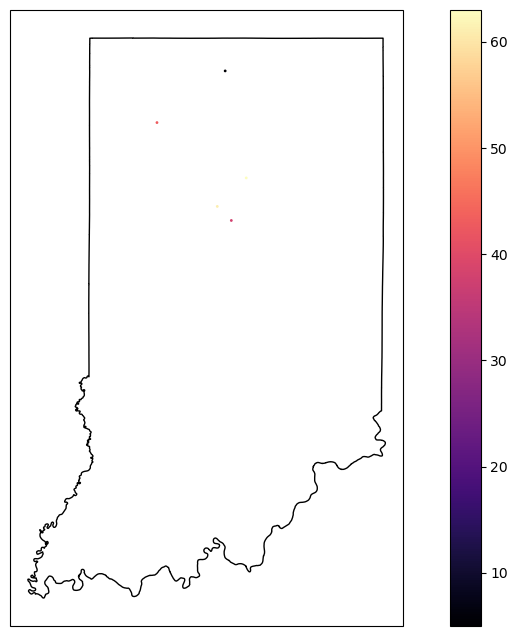

In [12]:
""" Pick a date and plot the snow """
projection = cartopy.crs.PlateCarree()
# pick a date
target_date = dt.datetime(2011, 2, 1)

ghcn_target = in_ghcn_gpd[in_ghcn_gpd.DATE == target_date]

# plot the snow
fig, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(12, 8))

ghcn_target.plot(ax = ax, transform = projection, column = "SNOW", legend = True, cmap = "magma", markersize = 1)

in_boundary_transform_gdf.plot(ax = ax, transform = projection, facecolor = 'none', edgecolor = 'black')

plt.show()

In [13]:
""" Calculate the total snow each year."""
# sum by year
in_snow_yearly_pd = in_ghcn_pd.groupby([in_ghcn_pd.DATE.dt.year, "STATION"])['SNOW'].sum().reset_index()

in_snow_yearly_pd.head()

,DATE,STATION,SNOW
0,1875,USW00093823,0.0
1,1883,USW00093823,0.0
2,1884,USW00093823,229.0
3,1885,USW00093823,623.0
4,1886,USW00093823,177.0


In [14]:
""" Calculate the trend in snow. """

# calculate the trend in snow
in_snow_trend_pd = in_snow_yearly_pd.groupby("STATION").apply(lambda x: scipy.stats.linregress(x['DATE'], x['SNOW'])[0]).reset_index()

# get the lat/lon for each station from the inventory
in_snow_trend_pd = in_snow_trend_pd.merge(in_snow_gdf[["ID", "LATITUDE", "LONGITUDE"]], left_on = "STATION", right_on = "ID").drop("ID", axis = 1)

# convert the dataframe to a geodataframe
in_snow_trend_gpd = gpd.GeoDataFrame(in_snow_trend_pd, geometry = gpd.points_from_xy(in_snow_trend_pd.LONGITUDE, in_snow_trend_pd.LATITUDE), crs = "EPSG:4326")

# rename the columns
in_snow_trend_gpd.columns = ["STATION", "TREND", "LATITUDE", "LONGITUDE", "geometry"]

in_snow_trend_gpd.head()

,STATION,TREND,LATITUDE,LONGITUDE,geometry
0,USC00120334,4.848962,41.3333,-85.0500,POINT (-85.05000 41.33330)
1,USC00120922,4.078820,39.5108,-87.1242,POINT (-87.12420 39.51080)
2,USC00121197,-11.182043,39.0500,-85.5500,POINT (-85.55000 39.05000)
3,USC00121256,-4.788842,37.8994,-86.7072,POINT (-86.70720 37.89940)
4,USC00121841,-4.732724,40.1397,-87.4067,POINT (-87.40670 40.13970)


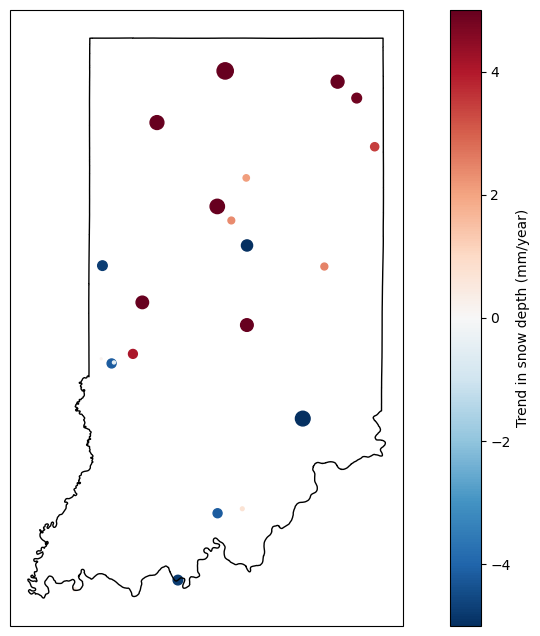

In [15]:
""" Plot the trend in snow. """

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=projection))

# plot the trends, using the trend magnitude as the color and marker size
in_snow_trend_gpd.plot(ax = ax, transform = projection, column = "TREND", legend = True, cmap = "RdBu_r", vmin = -5, vmax = 5, markersize = abs(in_snow_trend_gpd['TREND']) * 10, legend_kwds={'label': "Trend in snow depth (mm/year)"})

# plot the state boundary
in_boundary_transform_gdf.plot(ax = ax, transform = projection, facecolor = 'none', edgecolor = 'black')

plt.show()

